In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
def load_audio(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def audio_to_spectrogram(audio, sr=22050, n_fft=2048, hop_length=512):
    spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))
    return spectrogram_db

def plot_spectrogram(spectrogram, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=22050, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        return x

# Content and Style Loss definitions (using MSE for simplicity)
class ContentLoss(nn.Module):
    def forward(self, input, target):
        return nn.functional.mse_loss(input, target)

class StyleLoss(nn.Module):
    def gram_matrix(self, input):
        (b, ch, h, w) = input.size()
        features = input.view(b * ch, h * w)
        G = torch.mm(features, features.t())
        return G.div(b * ch * h * w)

    def forward(self, input, target):
        G_input = self.gram_matrix(input)
        G_target = self.gram_matrix(target)
        return nn.functional.mse_loss(G_input, G_target)


In [4]:
def style_transfer(content_spec, style_spec, cnn, num_steps=1000, content_weight=0.5, style_weight=1e6):
    content_spec = torch.tensor(content_spec).unsqueeze(0).unsqueeze(0).float().requires_grad_(False)
    style_spec = torch.tensor(style_spec).unsqueeze(0).unsqueeze(0).float().requires_grad_(False)
    
    # Extract features
    cnn.eval()
    content_features = cnn(content_spec)
    style_features = cnn(style_spec)
    
    # Define losses
    content_loss = ContentLoss()
    style_loss = StyleLoss()
    
    # Optimization setup
    input_spec = content_spec.clone().requires_grad_(True)
    optimizer = optim.Adam([input_spec], lr=0.01)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        
        input_features = cnn(input_spec)
        
        # Compute content and style losses
        c_loss = content_weight * content_loss(input_features, content_features)
        s_loss = style_weight * style_loss(input_features, style_features)
        
        # Combine losses
        total_loss = c_loss + s_loss
        total_loss.backward(retain_graph=True)  # Retain the computational graph
        
        # Update the spectrogram
        optimizer.step()
        
        if step % 50 == 0:
            print(f"Step {step}, Total Loss: {total_loss.item()}")

    # Detach the final result from the computational graph and return
    return input_spec.detach().cpu().numpy()


In [5]:
def spectrogram_to_audio(spectrogram_db, hop_length=512):
    spectrogram = librosa.db_to_amplitude(spectrogram_db)
    audio = librosa.istft(spectrogram, hop_length=hop_length)
    return audio


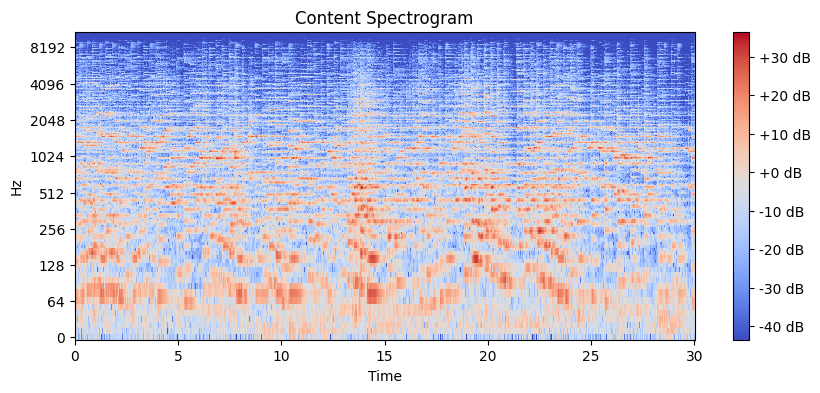

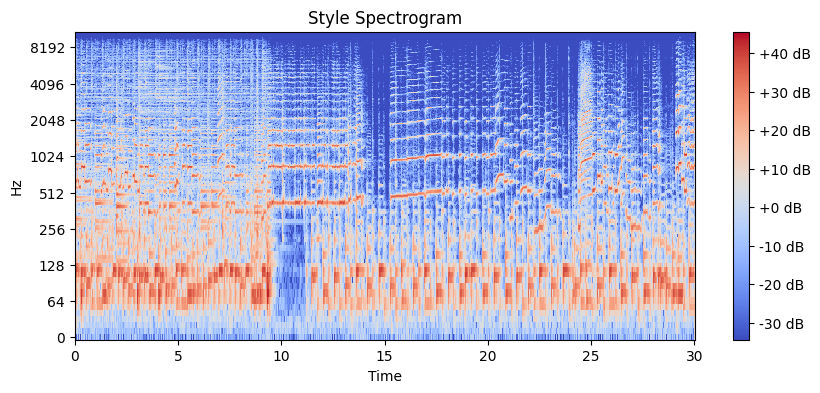

Step 0, Total Loss: 40.066165924072266
Step 50, Total Loss: 32.61658477783203
Step 100, Total Loss: 26.497058868408203
Step 150, Total Loss: 21.500730514526367
Step 200, Total Loss: 17.44211769104004
Step 250, Total Loss: 14.149064064025879
Step 300, Total Loss: 11.47253131866455
Step 350, Total Loss: 9.293525695800781
Step 400, Total Loss: 7.522646903991699
Step 450, Total Loss: 6.08670711517334
Step 500, Total Loss: 4.923174858093262
Step 550, Total Loss: 3.980675458908081
Step 600, Total Loss: 3.2192721366882324
Step 650, Total Loss: 2.60530686378479
Step 700, Total Loss: 2.1106488704681396
Step 750, Total Loss: 1.7131205797195435
Step 800, Total Loss: 1.3944811820983887
Step 850, Total Loss: 1.1396745443344116
Step 900, Total Loss: 0.9364467263221741
Step 950, Total Loss: 0.7747220396995544


In [6]:
content_file = '/kaggle/input/style-dataset/classical.00000.wav'
style_file = '/kaggle/input/style-dataset/jazz.00005.wav'

# Load and convert to spectrograms
content_audio = load_audio(content_file)
style_audio = load_audio(style_file)

content_spec = audio_to_spectrogram(content_audio)
style_spec = audio_to_spectrogram(style_audio)

# Display original spectrograms
plot_spectrogram(content_spec, title="Content Spectrogram")
plot_spectrogram(style_spec, title="Style Spectrogram")

# Initialize the CNN model
cnn = SimpleCNN()

# Perform style transfer
transferred_spec = style_transfer(content_spec, style_spec, cnn)

# Convert the resulting spectrogram back to audio
transferred_audio = spectrogram_to_audio(transferred_spec)

# Save or play the final result
#librosa.output.write_wav('transferred_audio.wav', transferred_audio, sr=22050)


In [15]:
import numpy as np
import soundfile as sf

# Flatten the output array to 1D
transferred_audio_flat = np.squeeze(transferred_audio)

# Save the audio file
sf.write('/kaggle/working/transferred_audio.wav', transferred_audio_flat, 22050)


In [16]:
# Save the audio file
sf.write('try_transferred_audio.wav', transferred_audio_flat, 22050)

In [17]:
# Save the audio file
sf.write('try2_transferred_audio.wav', transferred_audio_flat, 22050)

In [18]:
from IPython.display import Audio

# Play the audio file
Audio('/kaggle/working/transferred_audio.wav')


In [13]:
Audio('/kaggle/input/style-dataset/classical.00000.wav')

In [14]:
Audio('/kaggle/input/style-dataset/jazz.00005.wav')